In [1]:
import pandas as pd
import numpy as np
import statistics
from random import choice
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import copy
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score, mean_absolute_error, mean_squared_error
import math 
from scipy.linalg import cholesky 
from numpy.random import seed
from numpy.random import randint
from scipy.stats import spearmanr
import os
from sklearn.feature_selection import RFECV

import functions as func
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)


In [2]:
# Set gobal variables 
numcols = 0
numrows = 0
np.random.seed(42)
num = 277
#a=1.5 -> r=0.5 , a=0.5 -> r=0.15 , a=3.0 -> r=0.7, a=4.0 -> r=0.8
a = 4.0

In [3]:
def create_tree_png(dt, label, measure,num,a):
    """Creates a png of given Decision Tree

    Parameters
    ----------
    dt : DecisionTreeClassifier or DecisionTreeRegressor
        The Decision Tree to convert
    label : String
        A string used for file name
    measure : String
        A string used for file name
    num : int
        An int used for file name
    a : String
        A string used for file name
    """
    os.makedirs(os.path.dirname('graphs/dot/synthetic/all/%s/%s/best_pruned_%d_%s.dot'%(label,measure,num,a)), exist_ok = True)
    os.makedirs(os.path.dirname('graphs/synthetic/all/%s/%s/best_pruned_%d_%s.png'%(label,measure,num,a)), exist_ok = True)

    tree.export_graphviz(dt, out_file='graphs/dot/synthetic/all/%s/%s/best_pruned_%d_%s.dot'%(label,measure,num,a), feature_names= train_X.columns,
                        filled=True, rounded=True,special_characters=True)
    os.system("dot -T png graphs/dot/synthetic/all/%s/%s/best_pruned_%d_%s.dot -o graphs/synthetic/all/%s/%s/best_pruned_%d_%s.png"%(label,measure,num,a,label,measure,num,a))

def get_random_features(data,label,a=0.5,reg=False):
    """Creates random features matrix with respect to label distribution given in data. Adds noise.

    Parameters
    ----------
    data : pandas csv file
        The original data
    label : String
        Name of the label 
    a : float, optional
        Width of normal distribution to draw random samples for correlation matrix from. 
        Higher values mean higher correlations.
    reg : Boolean, optional
        A flag indicating if regression or classification scenario is considered
    
    Returns
    -------
    (DataFrame, DataFrame)
        generated features and corresponding labels as one DataFrame without noise
        , noisy features as DataFrame
    """
    # swap beste to front
    list1 = [-1]
    list2 = [i for i in range(numcols-1)]
    new_columns = list1 + list2
    data = data[data.columns[new_columns]]
    # create the Label 
    # seed random number generator
    seed(1)
    # check for class distribution in original data
    labels = []
    if reg and label != "Prog1_scaled":
        fractions = {}
        unique, counts = np.unique(data["%s"%(label)].values, return_counts=True)
        fractions = dict(zip(unique, counts))
        fractions.update({key: fractions[key]/numrows for key in fractions.keys()})
        marks = [100,130,170,200,230,270,300,330,370,400,500]
        for i in range(num):
            rnd = np.random.choice(marks,p=list(fractions.values()))
            labels.append(rnd)
    elif reg and label == "Prog1_scaled":
        fractions = {}
        unique, counts = np.unique(data["%s"%(label)].values, return_counts=True)
        fractions = dict(zip(unique, counts))
        fractions.update({key: fractions[key]/numrows for key in fractions.keys()})
        marks = [100,124.043025059752,130,148.080043771593,170,180.129402054054,
                 200,204.166420765875,228.203439477715,230,260.252797760176,270,284.289816471997,
                 300,308.326835183838,330,340.376193466299,364.41321217812,370,
                 400,444.536607884242,500]
        for i in range(num):
            rnd = np.random.choice(marks,p=list(fractions.values()))
            labels.append(rnd)
    else:
        zeros = 0
        ones = 0
        twos = 0
        for i in range(numrows):
            if data.iloc[i]["%s"%(label)] == 0:
                zeros += 1
            elif data.iloc[i]["%s"%(label)] == 1:
                ones += 1
            elif data.iloc[i]["%s"%(label)] == 2:
                twos += 1
        frac_z = zeros/numrows
        frac_o = ones/numrows
        frac_t = twos/numrows
        print(frac_z,frac_o,frac_t)
        for i in range(num):
            rnd = np.random.choice(np.arange(0, 3), p=[frac_z, frac_o, frac_t])
            labels.append(rnd)

    #generate Correlationmatrix
    n = 85
    if label == "MfI1_beste" or label =="beide":
        n = 86
        
    A = np.matrix([np.random.randn(n) + np.random.randn(1)*a for i in range(n)])
    A = A*np.transpose(A)
    D_half = np.diag(np.diag(A)**(-0.5))
    C = D_half*A*D_half
    corrs = np.argsort(np.abs(C[:,0]))
    corrs = np.sort(np.abs(np.array(C[0,:])))
    print(corrs[0])
    vals = list(np.array(C.ravel())[0])
    plt.hist(vals, range=(-1,1))
    plt.show()

    features = np.random.normal(0.0, 1.0, size=(num, numcols))
    features[:,0] = labels
    chol = cholesky(C) 
    features = features @ chol
    scaler = MinMaxScaler(feature_range=(0,1))
    features[:,1:] = scaler.fit_transform(features[:,1:])
    features = pd.DataFrame(data=features, columns=data.columns)
    #Check for change in labels
    print(np.max(np.abs(features["%s"%(label)]-labels))) 
    
    #Adding noise to data
    noise_rate = 0.1
    if reg:
        noise_rate = 0.5
     
    noise = [[0] * (numcols-1) for i in range(num)]
    noise = np.random.normal(-noise_rate, noise_rate, size=(num, numcols-1))
    X_noise = [sum(x) for x in zip(features.to_numpy()[:,1:], noise)]
    X_noise = pd.DataFrame(data=X_noise,columns=feature_names)
    return features, X_noise



[0.06305516 0.07285401 0.13681979 0.14420057 0.19694782 0.21123607
 0.21375046 0.22693215 0.23822097 0.26278227 0.32716641 0.40053899
 0.4585088  0.46986722 0.53757194 0.6159278  0.62585398 0.63685981
 0.63885305 0.69405629 0.74198799 0.77278937 0.7741798  0.79007113
 0.82490939 0.83045478 0.84386615 0.84755388 0.85290408 0.86415675
 0.86557866 0.87325617 0.87637501 0.87843796 0.88243806 0.88268967
 0.89155636 0.89212539 0.89290594 0.89350237 0.89623729 0.89688955
 0.89849132 0.90158015 0.90331098 0.90976604 0.91793859 0.91930495
 0.92140305 0.92439885 0.92690461 0.92807242 0.92878734 0.93110728
 0.93116411 0.93118436 0.93151726 0.93170973 0.93171068 0.9319432
 0.9320303  0.93294525 0.93364418 0.93375882 0.93381571 0.9338405
 0.9354857  0.93610165 0.93615458 0.9381035  0.93843432 0.93901914
 0.93972036 0.94081162 0.94110127 0.94119462 0.94170002 0.94394497
 0.94502605 0.94626368 0.94782381 0.94828813 0.94837615 0.94882056
 1.        ]


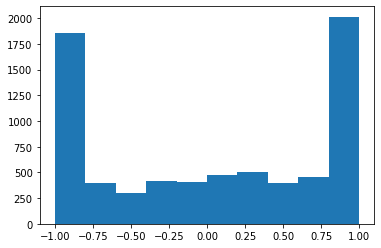

0.0
ACC  Prog1_beste
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 115 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 4579 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 12079 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 22579 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 36079 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  3.1min finished


Best parameter for ACC (CV score=0.4594)
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 1.0, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 20}
Scores: [0.40909091 0.45238095 0.42105263 0.51428571 0.5       ]
Mean: 0.4593620414673046
Standard deviation: 0.041741075095880334
[0.10230075 0.12314701 0.29234363 0.32058717 0.33874183 0.44474386
 0.47737384 0.51215258 0.62631465 0.64336164 0.66875837 0.69448319
 0.7276567  0.75223288 0.75322953 0.75955673 0.76889512 0.78666359
 0.7885897  0.79231852 0.7947743  0.7977959  0.80240649 0.81198665
 0.82408204 0.83067351 0.84307445 0.84480166 0.8454279  0.85604878
 0.86305633 0.87291161 0.8771884  0.88477212 0.88935463 0.89155449
 0.89562041 0.89691985 0.89951429 0.90022909 0.90479135 0.90753946
 0.90927614 0.91275499 0.91321467 0.91560503 0.91745483 0.91963676
 0.92008848 0.92118419 0.92264636 0.92266683 0.92463663 0.92514145
 0.9264816  0.92899327 0.92963819 0.93156973 0.93674444 0.93726432
 0.9378499  0.93929742 0.9

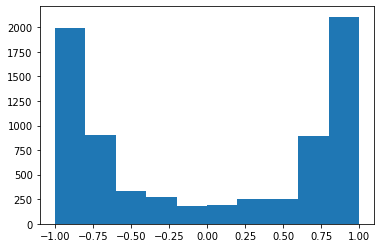

0.0
ACC  MfI1_beste
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


/home/franz/miniconda3/envs/mainenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 4424 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 10424 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 18824 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 29624 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 42824 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.8min finished


Best parameter for ACC (CV score=0.5073)
{'criterion': 'gini', 'max_depth': 3, 'max_features': 0.5, 'max_leaf_nodes': 10, 'min_samples_leaf': 20, 'min_samples_split': 2}
Scores: [0.47727273 0.42857143 0.51282051 0.52941176 0.58823529]
Mean: 0.5072623454976396
Standard deviation: 0.05323484950938387
[0.06305516 0.07285401 0.13681979 0.14420057 0.19694782 0.21123607
 0.21375046 0.22693215 0.23822097 0.26278227 0.32716641 0.40053899
 0.4585088  0.46986722 0.53757194 0.6159278  0.62585398 0.63685981
 0.63885305 0.69405629 0.74198799 0.77278937 0.7741798  0.79007113
 0.82490939 0.83045478 0.84386615 0.84755388 0.85290408 0.86415675
 0.86557866 0.87325617 0.87637501 0.87843796 0.88243806 0.88268967
 0.89155636 0.89212539 0.89290594 0.89350237 0.89623729 0.89688955
 0.89849132 0.90158015 0.90331098 0.90976604 0.91793859 0.91930495
 0.92140305 0.92439885 0.92690461 0.92807242 0.92878734 0.93110728
 0.93116411 0.93118436 0.93151726 0.93170973 0.93171068 0.9319432
 0.9320303  0.93294525 0.933644

/home/franz/miniconda3/envs/mainenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


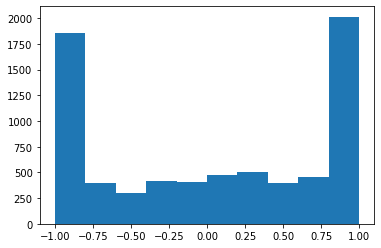

0.0
ACC  beste
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


/home/franz/miniconda3/envs/mainenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4424 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 10424 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 18824 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 29624 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 42824 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.8min finished
/home/franz/miniconda3/envs/mainenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 4 members, which 

Best parameter for ACC (CV score=0.4744)
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 0.75, 'max_leaf_nodes': 5, 'min_samples_leaf': 1, 'min_samples_split': 100}
Scores: [0.46511628 0.41860465 0.48717949 0.48571429 0.51515152]
Mean: 0.4743532436555693
Standard deviation: 0.03209770034235138
0.7153284671532847 0.2846715328467153 0.0
[0.06305516 0.07285401 0.13681979 0.14420057 0.19694782 0.21123607
 0.21375046 0.22693215 0.23822097 0.26278227 0.32716641 0.40053899
 0.4585088  0.46986722 0.53757194 0.6159278  0.62585398 0.63685981
 0.63885305 0.69405629 0.74198799 0.77278937 0.7741798  0.79007113
 0.82490939 0.83045478 0.84386615 0.84755388 0.85290408 0.86415675
 0.86557866 0.87325617 0.87637501 0.87843796 0.88243806 0.88268967
 0.89155636 0.89212539 0.89290594 0.89350237 0.89623729 0.89688955
 0.89849132 0.90158015 0.90331098 0.90976604 0.91793859 0.91930495
 0.92140305 0.92439885 0.92690461 0.92807242 0.92878734 0.93110728
 0.93116411 0.93118436 0.93151726 0.93170973 0.9317

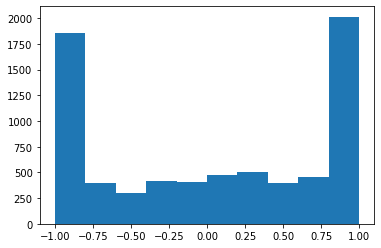

0.0
ACC  Prog1_beste
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 892 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 4792 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 11292 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 20392 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 32092 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 46392 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.1min finished


Best parameter for ACC (CV score=0.9013)
{'criterion': 'gini', 'max_depth': 3, 'max_features': 0.5, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Scores: [0.925      0.8974359  0.94736842 0.81578947 0.92105263]
Mean: 0.9013292847503374
Standard deviation: 0.04560950116811714
F1  Prog1_beste
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 8688 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 15688 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 24688 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 35688 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 48688 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.5min finished


Best parameter for F1 (CV score=0.8274)
{'criterion': 'gini', 'max_depth': 3, 'max_features': 0.5, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Scores: [0.88       0.83333333 0.9        0.66666667 0.85714286]
Mean: 0.8274285714285714
Standard deviation: 0.08341769879141554
AUC  Prog1_beste
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 8688 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 15688 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 24688 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 35688 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 48688 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.6min finished


Best parameter for AUC (CV score=0.9429)
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 0.5, 'max_leaf_nodes': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
Scores: [0.99553571 0.94444444 0.98148148 0.84848485 0.94444444]
Mean: 0.9428781866281867
Standard deviation: 0.05133816943653179
0.6048387096774194 0.3951612903225806 0.0
[0.10230075 0.12314701 0.29234363 0.32058717 0.33874183 0.44474386
 0.47737384 0.51215258 0.62631465 0.64336164 0.66875837 0.69448319
 0.7276567  0.75223288 0.75322953 0.75955673 0.76889512 0.78666359
 0.7885897  0.79231852 0.7947743  0.7977959  0.80240649 0.81198665
 0.82408204 0.83067351 0.84307445 0.84480166 0.8454279  0.85604878
 0.86305633 0.87291161 0.8771884  0.88477212 0.88935463 0.89155449
 0.89562041 0.89691985 0.89951429 0.90022909 0.90479135 0.90753946
 0.90927614 0.91275499 0.91321467 0.91560503 0.91745483 0.91963676
 0.92008848 0.92118419 0.92264636 0.92266683 0.92463663 0.92514145
 0.9264816  0.92899327 0.92963819 0.93156973 0.9367444

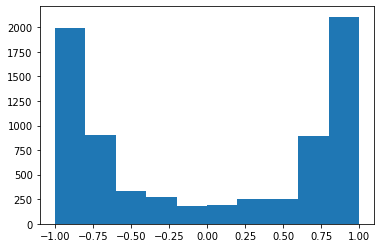

0.0
ACC  MfI1_beste
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 5160 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 12160 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 21960 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 34560 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 49960 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.2min finished


Best parameter for ACC (CV score=0.9376)
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 0.5, 'max_leaf_nodes': 10, 'min_samples_leaf': 3, 'min_samples_split': 2}
Scores: [0.95       0.94871795 0.97368421 0.89473684 0.92105263]
Mean: 0.9376383265856951
Standard deviation: 0.02716798628804775
F1  MfI1_beste
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 4424 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 10424 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 18824 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 29624 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 42824 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.5min finished


Best parameter for F1 (CV score=0.9264)
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 0.5, 'max_leaf_nodes': 10, 'min_samples_leaf': 3, 'min_samples_split': 2}
Scores: [0.94117647 0.9375     0.96774194 0.88235294 0.90322581]
Mean: 0.9263994307400379
Standard deviation: 0.03009284416135776
AUC  MfI1_beste
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 8688 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 15688 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 24688 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 35688 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 48688 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.5min finished


Best parameter for AUC (CV score=0.9584)
{'criterion': 'gini', 'max_depth': 3, 'max_features': 0.25, 'max_leaf_nodes': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
Scores: [0.95396419 0.95454545 0.94886364 0.97727273 0.95738636]
Mean: 0.9584064752383167
Standard deviation: 0.009825306177091386
0.7184115523465704 0.2815884476534296 0.0
[0.06305516 0.07285401 0.13681979 0.14420057 0.19694782 0.21123607
 0.21375046 0.22693215 0.23822097 0.26278227 0.32716641 0.40053899
 0.4585088  0.46986722 0.53757194 0.6159278  0.62585398 0.63685981
 0.63885305 0.69405629 0.74198799 0.77278937 0.7741798  0.79007113
 0.82490939 0.83045478 0.84386615 0.84755388 0.85290408 0.86415675
 0.86557866 0.87325617 0.87637501 0.87843796 0.88243806 0.88268967
 0.89155636 0.89212539 0.89290594 0.89350237 0.89623729 0.89688955
 0.89849132 0.90158015 0.90331098 0.90976604 0.91793859 0.91930495
 0.92140305 0.92439885 0.92690461 0.92807242 0.92878734 0.93110728
 0.93116411 0.93118436 0.93151726 0.93170973 0.9317106

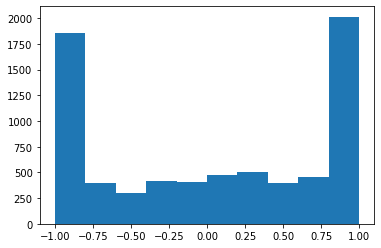

0.0
ACC  beste
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 5160 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 12160 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 21960 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 34560 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 49960 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.2min finished


Best parameter for ACC (CV score=0.9013)
{'criterion': 'gini', 'max_depth': 3, 'max_features': 0.5, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Scores: [0.925      0.8974359  0.94736842 0.81578947 0.92105263]
Mean: 0.9013292847503374
Standard deviation: 0.04560950116811714
F1  beste
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 3688 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 8688 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 15688 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 24688 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 35688 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 48688 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.5min finished


Best parameter for F1 (CV score=0.8274)
{'criterion': 'gini', 'max_depth': 3, 'max_features': 0.5, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Scores: [0.88       0.83333333 0.9        0.66666667 0.85714286]
Mean: 0.8274285714285714
Standard deviation: 0.08341769879141554
AUC  beste
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 892 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 4792 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 11292 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 20392 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 32092 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 46392 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.4min finished


Best parameter for AUC (CV score=0.9429)
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 0.5, 'max_leaf_nodes': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
Scores: [0.99553571 0.94444444 0.98148148 0.84848485 0.94444444]
Mean: 0.9428781866281867
Standard deviation: 0.05133816943653179
0.3181818181818182 0.21428571428571427 0.4675324675324675
[0.10230075 0.12314701 0.29234363 0.32058717 0.33874183 0.44474386
 0.47737384 0.51215258 0.62631465 0.64336164 0.66875837 0.69448319
 0.7276567  0.75223288 0.75322953 0.75955673 0.76889512 0.78666359
 0.7885897  0.79231852 0.7947743  0.7977959  0.80240649 0.81198665
 0.82408204 0.83067351 0.84307445 0.84480166 0.8454279  0.85604878
 0.86305633 0.87291161 0.8771884  0.88477212 0.88935463 0.89155449
 0.89562041 0.89691985 0.89951429 0.90022909 0.90479135 0.90753946
 0.90927614 0.91275499 0.91321467 0.91560503 0.91745483 0.91963676
 0.92008848 0.92118419 0.92264636 0.92266683 0.92463663 0.92514145
 0.9264816  0.92899327 0.92963819 0.93

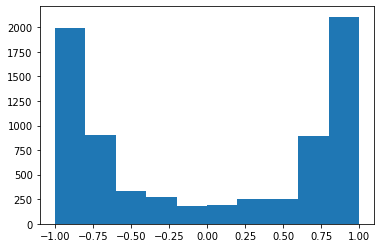

0.0
ACC  beide
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 892 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 4792 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 11292 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 20392 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 32092 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 46392 tasks      | elapsed:  1.8min


Best parameter for ACC (CV score=0.8972)
{'criterion': 'gini', 'max_depth': 3, 'max_features': 0.5, 'max_leaf_nodes': 10, 'min_samples_leaf': 3, 'min_samples_split': 10}
Scores: [0.87179487 0.8974359  0.87179487 0.87179487 0.97297297]
Mean: 0.8971586971586971
Standard deviation: 0.03918635519794273
Accuracy Trainingsdaten: [0.5181347150259067, 0.5544041450777202, 0.48186528497409326, 0.9844559585492227, 0.9740932642487047, 0.9844559585492227, 0.9585492227979274]
Accuracy Testdaten: [0.14285714285714285, 0.047619047619047616, 0.14285714285714285, 0.8809523809523809, 0.9166666666666666, 0.8809523809523809, 0.9404761904761905]
F1 Trainingsdaten: [[0], [0], [0], 0.9743589743589743, 0.9685534591194969, 0.9743589743589743, [0]]
F1 Testdaten: [[0], [0], [0], 0.7368421052631579, 0.8955223880597015, 0.7368421052631579, [0]]
AUC Trainingsdaten: [[0], [0], [0], 0.9903895768833849, 0.9954954954954954, 0.9903895768833849, [0]]
AUC Testdaten: [[0], [0], [0], 0.9444444444444444, 0.9348752282410225, 0

[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.0min finished


In [4]:
#Classification
#Variables to store intermediate results
dt_class = DecisionTreeClassifier(random_state=42)

predictions_acc_train = [[0] * num for i in range(7)]
predictions_acc_test = [[0] * num for i in range(7)]
predictions_f1_train = [[0] * num for i in range(7)]
predictions_f1_test = [[0] * num for i in range(7)]
predictions_auc_train = [[0] * num for i in range(7)]
predictions_auc_test = [[0] * num for i in range(7)]

probs_class_train = [[0] * num for i in range(7)]
probs_class_test = [[0] * num for i in range(7)]


acc_train = [[0] * 1 for i in range(7)]
acc_test = [[0] * 1 for i in range(7)]
f1_train = [[0] * 1 for i in range(7)]
f1_test = [[0] * 1 for i in range(7)]
auc_train = [[0] * 1 for i in range(7)]
auc_test = [[0] * 1 for i in range(7)]

#Lists of labels for each scenario
labels_class = ["Prog1_scaled","Prog1_beste", "MfI1_beste", "beste", "beide"]
others_class = [["Prog1_beste","MfI1_beste","beste","beide"],["MfI1_beste","beste","beide","Prog1_scaled"],["Prog1_beste","beste","beide","Prog1_scaled"],["Prog1_beste","MfI1_beste","beide","Prog1_scaled"]
         ,["Prog1_beste","MfI1_beste","beste","Prog1_scaled"]]
labels = ["Prog1_scaled","Prog1_beste", "MfI1_beste", "beste"]
others = [["Prog1_beste","MfI1_beste","beste"],["MfI1_beste","beste","Prog1_scaled"],["Prog1_beste","beste","Prog1_scaled"],["Prog1_beste","MfI1_beste","Prog1_scaled"]]


scenario = 0
other_count = 0


selector_acc = {}

# parameters to use in GridSearch
param_grid_class = {
    'criterion':('gini', 'entropy'),
    'max_depth':[3,4,5, 10, 15, 100,1000],
    'min_samples_split':[2,5,10,20, 40, 100],
    'min_samples_leaf':[1,3,5,20,100],
    'max_features':[0.25,0.5,0.75,1.0],
    'max_leaf_nodes':[5,10,20,30,100,1000],
    }

for label in labels:
    #Continuuos labels after normalization and scaling not suitable for accuracy
    if label == "Prog1_scaled":
        other_count+=1
        continue
    #Store results
    os.makedirs(os.path.dirname('Auswertung/scores/neu/%.1f/%d/cv_scores_classR.txt'%(a,num)), exist_ok = True) 
    f = open('Auswertung/scores/neu/%.1f/%d/cv_scores_classR.txt'%(a,num),'a')
    
    print("==============")
    f.write("========%s=======\n"%(label))
    
    #Load data
    data,_,y,train_X,test_X,train_y,test_y,names,feature_names,numcols,numrows = func.load_data_noten(label,others[other_count][0],others[other_count][1],others[other_count][2])
    features,X_noise = get_random_features(data,label,a=a,reg=True)
    y = round(features["%s"%(label)])
    X = features
    del X["%s"%(label)]
    train_Xn, test_Xn, train_yn, test_yn = train_test_split(X_noise,y,test_size=0.3,random_state=42)
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=42)
    
    #Cross_Validation on train data
    print("ACC ",label)
    grid = GridSearchCV(dt_class, param_grid_class, n_jobs=-1,iid=False, cv=5,verbose=1, scoring='accuracy')
    grid.fit(train_Xn, train_yn)
    f.write("Best parameter for ACC (CV score=%0.4f)\n" % (grid.best_score_))
    f.write('' + repr(grid.best_params_) + '\n')
    print("Best parameter for ACC (CV score=%0.4f)" % (grid.best_score_))
    print(grid.best_params_)
    best_dt_acc = grid.best_estimator_
    func.cross_val(best_dt_acc, train_Xn, train_yn, scoring="accuracy")

 
    
    #Fit and store predictions
    best_dt_acc.fit(train_Xn, train_yn)
    predictions_acc_train[scenario] = best_dt_acc.predict(train_Xn)
    predictions_acc_test[scenario] = best_dt_acc.predict(test_X)
    
    #Calculate performance
    acc_train[scenario] = accuracy_score(train_yn,predictions_acc_train[scenario])
    acc_test[scenario] = accuracy_score(test_y,predictions_acc_test[scenario])   
    scenario += 1
    other_count += 1
    f.close()
other_count = 0
for label in labels_class: 
    #Continuuos labels after normalization and scaling not suitable for accuracy
    if label == "Prog1_scaled":
        other_count+=1
        continue
    os.makedirs(os.path.dirname('Auswertung/scores/neu/%.1f/%d/cv_scores_class.txt'%(a,num)), exist_ok = True) 
    f = open('Auswertung/scores/neu/%.1f/%d/cv_scores_class.txt'%(a,num),'a')
    
    print("================")
    f.write("========%s=======\n"%(label))
    #Load data
    
    data,_,y,train_X,test_X,train_y,test_y,names,feature_names,numcols,numrows = func.load_data_bestanden(label,others_class[other_count][0],
                                                                 others_class[other_count][1],
                                                                 others_class[other_count][2])
    features,X_noise = get_random_features(data,label,a=a)
    y = round(features["%s"%(label)])
    X = features
    del X["%s"%(label)]
    

    train_Xn, test_Xn, train_yn, test_yn = train_test_split(X_noise,y,test_size=0.3,random_state=42)
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=42)
    
    
    #Cross_Validation on train data
    print("ACC ",label)
    grid = GridSearchCV(dt_class, param_grid_class, n_jobs=-1,iid=False, cv=5,verbose=1, scoring='accuracy')
    grid.fit(train_Xn, train_yn)
    f.write("Best parameter for ACC (CV score=%0.4f) \n" % (grid.best_score_))
    f.write('' + repr(grid.best_params_) + '\n')
    print("Best parameter for ACC (CV score=%0.4f)" % (grid.best_score_))
    print(grid.best_params_)
    best_dt_acc = grid.best_estimator_
    func.cross_val(best_dt_acc, train_Xn, train_yn, scoring="accuracy")
    
    #fit and store predictions
    best_dt_acc.fit(train_Xn, train_yn)
    predictions_acc_train[scenario] = best_dt_acc.predict(train_Xn)
    predictions_acc_test[scenario] = best_dt_acc.predict(test_X)
    create_tree_png(best_dt_acc,label,"accuracy",num,a)
    
    #Calculate performance
    acc_train[scenario] = accuracy_score(train_yn,predictions_acc_train[scenario])
    acc_test[scenario] = accuracy_score(test_y,predictions_acc_test[scenario])
    
    # If label==beide only accuracy can be calculated
    if(label!="beide"):
        print("F1 ",label)
        grid = GridSearchCV(dt_class, param_grid_class, n_jobs=-1,iid=False, cv=5,verbose=1, scoring='f1')
        grid.fit(train_Xn, train_yn)
        f.write("Best parameter for F1 (CV score=%0.4f)\n" % (grid.best_score_))
        f.write('' + repr(grid.best_params_) + '\n')
        print("Best parameter for F1 (CV score=%0.4f)" % (grid.best_score_))
        print(grid.best_params_)
        best_dt_f1 = grid.best_estimator_
        func.cross_val(best_dt_f1, train_Xn, train_yn, scoring="f1")


        print("AUC ",label)
    
        grid = GridSearchCV(dt_class, param_grid_class, n_jobs=-1,iid=False, cv=5,verbose=1, scoring='roc_auc')
        grid.fit(train_Xn, train_yn)
        f.write("Best parameter for AUC (CV score=%0.4f)\n" % (grid.best_score_))
        f.write('' + repr(grid.best_params_) + '\n')
        print("Best parameter for AUC (CV score=%0.4f)" % (grid.best_score_))
        print(grid.best_params_)
        best_dt_auc = grid.best_estimator_
        func.cross_val(best_dt_auc, train_Xn, train_yn, scoring="roc_auc")

        #Fit and store predictions
        best_dt_f1.fit(train_Xn, train_yn)
        predictions_f1_train[scenario] = best_dt_f1.predict(train_Xn)
        predictions_f1_test[scenario] = best_dt_f1.predict(test_X)
        create_tree_png(best_dt_f1,label,"f1",num,a)
        
        best_dt_auc.fit(train_Xn, train_yn)
        create_tree_png(best_dt_auc,label,"roc_auc",num,a)
        
        #Calculate Performance
        f1_train[scenario] = f1_score(train_yn,predictions_f1_train[scenario])
        f1_test[scenario] = f1_score(test_y,predictions_f1_test[scenario]) 
        probs_class_train[scenario] = best_dt_auc.predict_proba(train_Xn)
        probs_class_train[scenario]  = probs_class_train[scenario][:, 1]
        probs_class_test[scenario] = best_dt_auc.predict_proba(test_X)
        probs_class_test[scenario]  = probs_class_test[scenario][:, 1]
        auc_train[scenario] = roc_auc_score(train_yn,probs_class_train[scenario])
        auc_test[scenario] = roc_auc_score(test_y,probs_class_test[scenario]) 
    scenario += 1
    other_count += 1
    f.close()

os.makedirs(os.path.dirname('Auswertung/scores/neu/%.1f/%d/scores.txt'%(a,num)), exist_ok = True) 
    
f = open('Auswertung/scores/neu/%.1f/%d/scores.txt'%(a,num),'a')

print("Accuracy Trainingsdaten:", acc_train)
print("Accuracy Testdaten:",acc_test)
print("F1 Trainingsdaten:", f1_train)
print("F1 Testdaten:",f1_test)
print("AUC Trainingsdaten:", auc_train)
print("AUC Testdaten:",auc_test)

f.write("Accuracy Trainingsdaten: "+ repr(acc_train)+"\n")
f.write("Accuracy Testdaten: "+ repr(acc_test)+"\n")
f.write("F1 Trainingsdaten: "+ repr(f1_train)+"\n")
f.write("F1 Testdaten: "+ repr(f1_test)+"\n")
f.write("AUC Trainingsdaten: "+ repr(auc_train)+"\n")
f.write("AUC Testdaten: "+ repr(auc_train)+"\n")

f.close()

[0.06305516 0.07285401 0.13681979 0.14420057 0.19694782 0.21123607
 0.21375046 0.22693215 0.23822097 0.26278227 0.32716641 0.40053899
 0.4585088  0.46986722 0.53757194 0.6159278  0.62585398 0.63685981
 0.63885305 0.69405629 0.74198799 0.77278937 0.7741798  0.79007113
 0.82490939 0.83045478 0.84386615 0.84755388 0.85290408 0.86415675
 0.86557866 0.87325617 0.87637501 0.87843796 0.88243806 0.88268967
 0.89155636 0.89212539 0.89290594 0.89350237 0.89623729 0.89688955
 0.89849132 0.90158015 0.90331098 0.90976604 0.91793859 0.91930495
 0.92140305 0.92439885 0.92690461 0.92807242 0.92878734 0.93110728
 0.93116411 0.93118436 0.93151726 0.93170973 0.93171068 0.9319432
 0.9320303  0.93294525 0.93364418 0.93375882 0.93381571 0.9338405
 0.9354857  0.93610165 0.93615458 0.9381035  0.93843432 0.93901914
 0.93972036 0.94081162 0.94110127 0.94119462 0.94170002 0.94394497
 0.94502605 0.94626368 0.94782381 0.94828813 0.94837615 0.94882056
 1.        ]


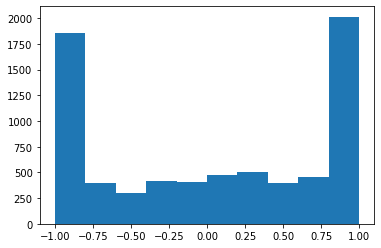

0.0
RMSE  Prog1_scaled
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 5896 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 13896 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 25096 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 37624 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 46424 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  3.2min finished


Best parameter for RMSE (CV score=-8438.6385):
{'criterion': 'mae', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'min_samples_split': 2}
Scores: [ 82.19177075  89.48112536  98.69819316 102.13059235  85.19883864]
Mean: 91.54010405249315
Standard deviation: 7.68425738748948
MAE  Prog1_scaled
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 5528 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 13028 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 23528 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 37028 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 46508 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  3.2min finished


Best parameter for MAE (CV score=-68.9108):
{'criterion': 'mae', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'min_samples_split': 2}
Scores: [-54.46153846 -68.71794872 -74.76923077 -82.34210526 -64.26315789]
Mean: -68.91079622132253
Standard deviation: 9.435466071290799
[0.06305516 0.07285401 0.13681979 0.14420057 0.19694782 0.21123607
 0.21375046 0.22693215 0.23822097 0.26278227 0.32716641 0.40053899
 0.4585088  0.46986722 0.53757194 0.6159278  0.62585398 0.63685981
 0.63885305 0.69405629 0.74198799 0.77278937 0.7741798  0.79007113
 0.82490939 0.83045478 0.84386615 0.84755388 0.85290408 0.86415675
 0.86557866 0.87325617 0.87637501 0.87843796 0.88243806 0.88268967
 0.89155636 0.89212539 0.89290594 0.89350237 0.89623729 0.89688955
 0.89849132 0.90158015 0.90331098 0.90976604 0.91793859 0.91930495
 0.92140305 0.92439885 0.92690461 0.92807242 0.92878734 0.93110728
 0.93116411 0.93118436 0.93151726 0.93170973 0.93171068 0.9319432
 0.9320303  0.932945

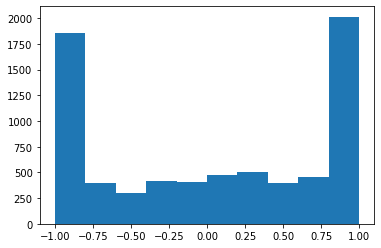

0.0
RMSE  Prog1_beste
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 5528 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 13028 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 23528 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 32468 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 40718 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  3.2min finished


Best parameter for RMSE (CV score=-6705.7981):
{'criterion': 'mse', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 2}
Scores: [90.61436183 78.86273154 67.46135704 89.93374802 80.37153593]
Mean: 81.4487468736721
Standard deviation: 8.47937114745791
MAE  Prog1_beste
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 5528 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 13028 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 23528 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 32708 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 40958 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  3.3min finished


Best parameter for MAE (CV score=-59.2840):
{'criterion': 'mse', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': 25, 'min_samples_leaf': 5, 'min_samples_split': 2}
Scores: [-64.68131868 -55.08180708 -51.87820513 -63.91144528 -60.86716792]
Mean: -59.28398881819934
Standard deviation: 5.011086557471141
[0.10230075 0.12314701 0.29234363 0.32058717 0.33874183 0.44474386
 0.47737384 0.51215258 0.62631465 0.64336164 0.66875837 0.69448319
 0.7276567  0.75223288 0.75322953 0.75955673 0.76889512 0.78666359
 0.7885897  0.79231852 0.7947743  0.7977959  0.80240649 0.81198665
 0.82408204 0.83067351 0.84307445 0.84480166 0.8454279  0.85604878
 0.86305633 0.87291161 0.8771884  0.88477212 0.88935463 0.89155449
 0.89562041 0.89691985 0.89951429 0.90022909 0.90479135 0.90753946
 0.90927614 0.91275499 0.91321467 0.91560503 0.91745483 0.91963676
 0.92008848 0.92118419 0.92264636 0.92266683 0.92463663 0.92514145
 0.9264816  0.92899327 0.92963819 0.93156973 0.93674444 0.93726432
 0.9378499  0.939297

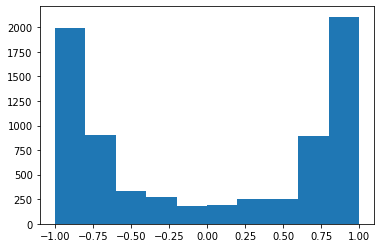

0.0
RMSE  MfI1_beste
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1164 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 6264 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 14764 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 26664 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 35130 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 44480 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  3.3min finished


Best parameter for RMSE (CV score=-6074.8149):
{'criterion': 'mse', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': 30, 'min_samples_leaf': 3, 'min_samples_split': 2}
Scores: [76.28048407 72.10692638 82.12523444 81.86828406 76.8699108 ]
Mean: 77.85016795183415
Standard deviation: 3.7638035506205854
MAE  MfI1_beste
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 9336 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 22336 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 34478 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 46178 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.9min finished


Best parameter for MAE (CV score=-52.2308):
{'criterion': 'mae', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': 20, 'min_samples_leaf': 3, 'min_samples_split': 2}
Scores: [-61.28205128 -55.38461538 -39.48717949 -50.26315789 -54.73684211]
Mean: -52.23076923076924
Standard deviation: 7.272185744449518
[0.06305516 0.07285401 0.13681979 0.14420057 0.19694782 0.21123607
 0.21375046 0.22693215 0.23822097 0.26278227 0.32716641 0.40053899
 0.4585088  0.46986722 0.53757194 0.6159278  0.62585398 0.63685981
 0.63885305 0.69405629 0.74198799 0.77278937 0.7741798  0.79007113
 0.82490939 0.83045478 0.84386615 0.84755388 0.85290408 0.86415675
 0.86557866 0.87325617 0.87637501 0.87843796 0.88243806 0.88268967
 0.89155636 0.89212539 0.89290594 0.89350237 0.89623729 0.89688955
 0.89849132 0.90158015 0.90331098 0.90976604 0.91793859 0.91930495
 0.92140305 0.92439885 0.92690461 0.92807242 0.92878734 0.93110728
 0.93116411 0.93118436 0.93151726 0.93170973 0.93171068 0.9319432
 0.9320303  0.9329452

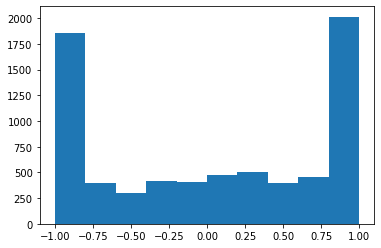

0.0
RMSE  beste
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1164 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 6264 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 14764 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 26664 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 40757 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 50107 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.9min finished


Best parameter for RMSE (CV score=-6636.9985):
{'criterion': 'mse', 'max_depth': 5, 'max_features': 1.0, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 2}
Scores: [90.15373449 83.5455287  67.0841597  88.02443783 76.34694053]
Mean: 81.03096025063726
Standard deviation: 8.425082543125876
MAE  beste
Fitting 5 folds for each of 10080 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 5160 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 12160 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 21960 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 34560 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 49960 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 50400 out of 50400 | elapsed:  2.9min finished


Best parameter for MAE (CV score=-57.5332):
{'criterion': 'mse', 'max_depth': 10, 'max_features': 0.75, 'max_leaf_nodes': 25, 'min_samples_leaf': 1, 'min_samples_split': 10}
Scores: [-64.3482906  -54.84859585 -50.02747253 -67.27339181 -51.16812865]
Mean: -57.53317588843904
Standard deviation: 7.005340448262544
RMSE Trainingsdaten: [1.03813303928441, 34.021049433601526, 22.51581737186487, 36.5555485162202]
RMSE Testdaten: [140.36092930794695, 117.81970342383718, 96.76604381314385, 128.57515867604997]
MAE Trainingsdaten: [0.14507772020725387, 20.4053787318036, 14.61139896373057, 16.627513554081357]
MAE Testdaten: [110.11904761904762, 87.73809523809524, 57.142857142857146, 97.71620142309796]


In [6]:
# Regression
dt_reg = DecisionTreeRegressor(random_state=42)

#Variables to store intermediate results
predictions_rmse_train = [[0] * num for i in range(4)]
predictions_rmse_test = [[0] * num for i in range(4)]
predictions_mae_train = [[0] * num for i in range(4)]
predictions_mae_test = [[0] * num for i in range(4)]

rmse_reg_train = [[0] * 1 for i in range(4)]
rmse_reg_test = [[0] * 1 for i in range(4)]
mae_reg_train = [[0] * 1 for i in range(4)]
mae_reg_test = [[0] * 1 for i in range(4)]

#Lists of labels for each scenario
labels = ["Prog1_scaled","Prog1_beste", "MfI1_beste", "beste"]
others = [["Prog1_beste","MfI1_beste","beste"],["MfI1_beste","beste","Prog1_scaled"],["Prog1_beste","beste","Prog1_scaled"],["Prog1_beste","MfI1_beste","Prog1_scaled"]]


scenario = 0
other_count = 0

#Parameters to use in GridSearch
param_grid = {
    'criterion':('mse', 'mae'),
    'max_depth':[3,4,5, 10,15, 100,1000],
    'min_samples_split':[2,5,10,20, 40,100],
    'min_samples_leaf':[1,3,5,20,100],
    'max_features':[0.25,0.5,0.75,1.0],
    'max_leaf_nodes':[5,10,20,25,30,100],
    }

for label in labels:  
    os.makedirs(os.path.dirname('Auswertung/scores/neu/%.1f/%d/cv_scores_reg.txt'%(a,num)), exist_ok = True) 
    f = open('Auswertung/scores/neu/%.1f/%d/cv_scores_reg.txt'%(a,num),'a')
    print("=============")
    f.write("========%s=======\n"%(label))

    #Load data
    data,_,y,train_X,test_X,train_y,test_y,names,feature_names,numcols,numrows = func.load_data_noten(label,others[other_count][0],others[other_count][1],others[other_count][2])
    features,X_noise = get_random_features(data,label,a=a,reg=True)
    y = round(features["%s"%(label)])
    X = features
    del X["%s"%(label)]
    train_Xn, test_Xn, train_yn, test_yn = train_test_split(X_noise,y,test_size=0.3,random_state=42)
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=42)
    
    
    #Cross_Validation on train data
    print("RMSE ",label)
    grid = GridSearchCV(dt_reg, param_grid, n_jobs=-1,iid=False, cv=5,verbose=1, scoring='neg_mean_squared_error')
    grid.fit(train_Xn, train_yn)
    f.write("Best parameter for RMSE (CV score=%0.4f)\n" % (sqrt(-1*grid.best_score_)))
    f.write('' + repr(grid.best_params_) + '\n')
    print("Best parameter for RMSE (CV score=%0.4f):" % (grid.best_score_))
    print(grid.best_params_)
    best_dt_rmse = grid.best_estimator_
    func.cross_val(best_dt_rmse, train_Xn, train_yn, scoring="neg_mean_squared_error")
    
    print("MAE ",label)
    grid = GridSearchCV(dt_reg, param_grid, n_jobs=-1,iid=False, cv=5,verbose=1, scoring='neg_mean_absolute_error')
    grid.fit(train_Xn, train_yn)
    f.write("Best parameter for MAE (CV score=%0.4f)\n" % (grid.best_score_))
    f.write('' + repr(grid.best_params_) + '\n')
    print("Best parameter for MAE (CV score=%0.4f):" % (grid.best_score_))
    print(grid.best_params_)
    best_dt_mae = grid.best_estimator_
    func.cross_val(best_dt_mae, train_Xn, train_yn, scoring="neg_mean_absolute_error")
    
    
    #Fit and store predictions
    best_dt_rmse.fit(train_Xn, train_yn)
    predictions_rmse_train[scenario] = best_dt_rmse.predict(train_Xn)
    predictions_rmse_test[scenario] = best_dt_rmse.predict(test_X)
    create_tree_png(best_dt_rmse,label,"rmse",num,a)
    
    best_dt_mae.fit(train_Xn, train_yn)
    predictions_mae_train[scenario] = best_dt_mae.predict(train_Xn)
    predictions_mae_test[scenario] = best_dt_mae.predict(test_X)
    create_tree_png(best_dt_mae,label,"mae",num,a)
    
    #Calculate performance
    rmse_reg_train[scenario] = sqrt(mean_squared_error(train_yn,predictions_rmse_train[scenario]))
    rmse_reg_test[scenario] = sqrt(mean_squared_error(test_y,predictions_rmse_test[scenario]))

    mae_reg_train[scenario] = mean_absolute_error(train_yn,predictions_mae_train[scenario])
    mae_reg_test[scenario] = mean_absolute_error(test_y,predictions_mae_test[scenario])
    scenario += 1
    other_count += 1
    f.close()

os.makedirs(os.path.dirname('Auswertung/scores/neu/%.1f/%d/scores.txt'%(a,num)), exist_ok = True) 
    
f = open('Auswertung/scores/neu/%.1f/%d/scores.txt'%(a,num),'a')

print("RMSE Trainingsdaten:", rmse_reg_train)
print("RMSE Testdaten:",rmse_reg_test)
print("MAE Trainingsdaten:",mae_reg_train)
print("MAE Testdaten:",mae_reg_test)

f.write("=====Regression=====\n")
f.write("RMSE Trainingsdaten: "+ repr(rmse_reg_train)+"\n")
f.write("RMSE Testdaten: "+ repr(rmse_reg_test)+"\n")
f.write("MAE Trainingsdaten: "+ repr(mae_reg_train)+"\n")
f.write("MAE Testdaten: "+ repr(mae_reg_test)+"\n")
f.close()